# **Modelamiento**

Se van a revisar los datos y hacer dos modelos para responder a cada una de las preguntas.

In [95]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from io import StringIO

## **Revision de Datos**
Se revisa los arcihvos de la carpeta para poder importar los datos necesarios.

In [96]:
os.getcwd()
os.listdir()

['X_data.pkl',
 'scaler.pkl',
 'datos',
 '.DS_Store',
 'model_evaluations.xlsx',
 'limpieza_y_alistamiento.ipynb',
 'best_model.pkl',
 'README.md',
 'multivariate_regression_model.csv',
 'model_desarrollo.ipynb',
 '.git',
 'datos_limpios.csv',
 'univariate_regression_model.csv',
 'col_date.xlsx']

In [97]:
df=pd.read_csv('datos_limpios.csv')
df.sample(6)

,date,department,day,team,targeted_productivity,smv,over_time,incentive,actual_productivity,dia_del_año,no_of_workers_redondeado
256,2015-01-14,finishing,Wednesday,10,0.80,3.94,1260,0,0.332359,14,8
1022,2015-03-02,finishing,Monday,12,0.80,4.60,3780,0,0.607654,61,9
367,2015-01-21,sweing,Wednesday,9,0.80,54.56,4140,29,0.520238,21,58
515,2015-01-29,sweing,Thursday,6,0.50,18.79,3960,23,0.500118,29,33
170,2015-01-11,finishing,Sunday,3,0.75,4.15,1440,0,0.935322,11,8
945,2015-02-26,sweing,Thursday,7,0.80,30.10,4080,50,0.800809,57,59


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      1197 non-null   object 
 1   department                1197 non-null   object 
 2   day                       1197 non-null   object 
 3   team                      1197 non-null   int64  
 4   targeted_productivity     1197 non-null   float64
 5   smv                       1197 non-null   float64
 6   over_time                 1197 non-null   int64  
 7   incentive                 1197 non-null   int64  
 8   actual_productivity       1197 non-null   float64
 9   dia_del_año               1197 non-null   int64  
 10  no_of_workers_redondeado  1197 non-null   int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 103.0+ KB


## **Modelo 1: Regresion lineal**

### **Modelo Descriptivo**

Se usa un modelo de regresion lineal para poder responder a nuestra primera pregunta:

#### ¿El número de trabajadores en un equipo y el incentivo mejoran el rendimiento (medido con el porcentaje real de productividad)?

In [99]:
df_sample=df.copy()

##### Se genera un modelo de regresion inicial donde solo se incluyen las dos variables de interes para explicar:

$$\text{Actual Productivity}_i = \beta_0 + \beta_1 \text{ Incentive}_i + \beta_2 \text{ Numbers of Workers}_i$$

In [100]:
X = df_sample[['incentive', 'no_of_workers_redondeado']]
y = df_sample['actual_productivity']
X = sm.add_constant(X)  

model = sm.OLS(y, X).fit()

model_summary = model.summary()
model_summary#

X = df_sample[['incentive', 'no_of_workers_redondeado']]
y = df_sample['actual_productivity']
X = sm.add_constant(X) 


model = sm.OLS(y, X).fit()

model_summary = model.summary()
model_summary

model_summary.tables[1]

table_output=model_summary.tables[1]

html_table = table_output.as_html()
df_list = pd.read_html(StringIO(html_table))

table_output = df_list[0]
table_output

table_output.columns=table_output.iloc[0]

table_output.rename(columns={table_output.columns[0]: 'parameters'}, inplace=True)

filtered_table = table_output[table_output['parameters'].isin(["incentive", "no_of_workers_redondeado"])]
filtered_table

filtered_table.to_csv("univariate_regression_model.csv", index=False)

filtered_table

model_summary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.7488,0.009,80.136,0.000,0.730,0.767
incentive,8.672e-05,3.14e-05,2.761,0.006,2.51e-05,0.000
no_of_workers_redondeado,-0.0005,0.000,-2.173,0.030,-0.001,-4.79e-05


In [101]:
df_sample.columns

Index(['date', 'department', 'day', 'team', 'targeted_productivity', 'smv',
       'over_time', 'incentive', 'actual_productivity', 'dia_del_año',
       'no_of_workers_redondeado'],
      dtype='object')

### Arreglo de datos: Modelo Regresion
Aqui se elimina un error de type que tenian los datos de "departamento" donde habia un espacio en algunas de las filas que tenian "finishing". Se hace aqui porque fue un error que no se habia notado antes y fue necesario para poder correr el modelo.

In [102]:
df_sample["department"]=[_.strip() for _ in  df_sample["department"]]
df_sample["department"].value_counts()

df_sample["day"].value_counts()

df_sample["team"].value_counts()

team
8     109
2     109
1     105
4     105
9     104
10    100
12     99
7      96
3      95
6      94
5      93
11     88
Name: count, dtype: int64

#
Aqui se vuelven dummies la variables 'department' y 'day' haciendo k-1 variables dummies, donde k seria el numero de valores que podia tomar cada variable. En caso de 'department' solo dos variables y para 'day' siete valores. 
Por otro lado, la variable team funcionaba como una falsa numerica dado que estos eran los numeros de los equipos y no como tal un numero para el modelo, por lo que se convierte, con la misma condicion de k-1, en la tercrea dummie. Ademas,
Se elimina la variable 'date' dado que no es necesaria para el modelo y esta fue remplazada por la variable 'dia_del_año' en la limpieza.

In [103]:
df_sample = df_sample.drop(columns=["date"])

df_encoded = pd.get_dummies(df_sample, columns=['department', 'day', "team"], drop_first=True)

df_encoded = df_encoded.astype(int)

df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   targeted_productivity     1197 non-null   int64
 1   smv                       1197 non-null   int64
 2   over_time                 1197 non-null   int64
 3   incentive                 1197 non-null   int64
 4   actual_productivity       1197 non-null   int64
 5   dia_del_año               1197 non-null   int64
 6   no_of_workers_redondeado  1197 non-null   int64
 7   department_sweing         1197 non-null   int64
 8   day_Saturday              1197 non-null   int64
 9   day_Sunday                1197 non-null   int64
 10  day_Thursday              1197 non-null   int64
 11  day_Tuesday               1197 non-null   int64
 12  day_Wednesday             1197 non-null   int64
 13  team_2                    1197 non-null   int64
 14  team_3                    1197 non-null 

### Calculo del Modelo de Regresion con controles.

Aqui se incorporan al modelo de regresión las demas variables que se tienen en la matriz del dataframe con el fin de reducir el sesgo de los estimadores y volverlos mas consistentes.


$$\text{Actual Productivity}_i = \beta_0 + \beta_1 \text{ Incentive}_i + \beta_2 \text{ Numbers of Workers}_i + \beta_3 \text{Targeted Productivity}_i + \beta_4 \text{ SMV}_i + \beta_5 \text{Over Time}_i + \beta_6 \text{Dia del Año }_i + \beta_7 \text{ Departament Sweing}_i $$

$$+ \beta_8 \text{ Saturday}_i + \beta_9 \text{ Sunday}_i + \beta_{10} \text{ Thursday}_i + \beta_{11} \text{ Tuesday}_i + \beta_{12} \text{ Wednesday}_i + \beta_{13} \text{ Team 2}_i + \beta_{14} \text{ Team 3}_i + \beta_{15} \text{ Team 4}_i + \beta_{16} \text{ Team 5}_i + \beta_{17} \text{ Team 6}_i + \beta_{18} \text{ Team 7}_i $$

$$+ \beta_{19} \text{ Team 8}_i + \beta_{20} \text{ Team 9}_i + \beta_{21} \text{ Team 10}_i + \beta_{22} \text{ Team 11}_i + \beta_{23} \text{ Team 12}_i $$

In [104]:
indenpendent_vars=[_ for _ in df_encoded.columns if _!='actual_productivity' ]
indenpendent_vars

['targeted_productivity',
 'smv',
 'over_time',
 'incentive',
 'dia_del_año',
 'no_of_workers_redondeado',
 'department_sweing',
 'day_Saturday',
 'day_Sunday',
 'day_Thursday',
 'day_Tuesday',
 'day_Wednesday',
 'team_2',
 'team_3',
 'team_4',
 'team_5',
 'team_6',
 'team_7',
 'team_8',
 'team_9',
 'team_10',
 'team_11',
 'team_12']

In [105]:
X =  df_encoded[indenpendent_vars]
y =  df_encoded['actual_productivity']
X = sm.add_constant(X)  

model = sm.OLS(y, X).fit()

model_summary = model.summary()
model_summary

model_summary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.0703,0.025,2.834,0.005,0.022,0.119
targeted_productivity,1.272e-13,4.61e-14,2.759,0.006,3.67e-14,2.18e-13
smv,-0.0034,0.001,-3.008,0.003,-0.006,-0.001
over_time,-8.241e-06,2.3e-06,-3.576,0.000,-1.28e-05,-3.72e-06
incentive,3.855e-05,3.08e-05,1.252,0.211,-2.19e-05,9.9e-05
dia_del_año,-0.0003,0.000,-1.206,0.228,-0.001,0.000
no_of_workers_redondeado,0.0044,0.001,4.436,0.000,0.002,0.006
department_sweing,-0.0639,0.038,-1.674,0.094,-0.139,0.011
day_Saturday,0.0112,0.017,0.656,0.512,-0.022,0.045
day_Sunday,0.0191,0.017,1.136,0.256,-0.014,0.052


In [106]:
f_statistic = model.fvalue
p_value = model.f_pvalue

print("F-statistic:", f_statistic)
print("p-value:", p_value)

F-statistic: 5.5624049382745495
p-value: 5.1888888365254124e-15


In [107]:
table_output=model_summary.tables[1]

html_table = table_output.as_html()
df_list = pd.read_html(StringIO(html_table))

table_output = df_list[0]
table_output

table_output.columns=table_output.iloc[0]

table_output.rename(columns={table_output.columns[0]: 'parameters'}, inplace=True)

filtered_table = table_output[table_output['parameters'].isin(["incentive", "no_of_workers_redondeado"])]

filtered_table.to_csv("multivariate_regression_model.csv", index=False)

filtered_table

,parameters,coef,std err,t,P>|t|,[0.025,0.975]
5,incentive,3.855e-05,3.08e-05,1.252,0.211,-2.19e-05,9.9e-05
7,no_of_workers_redondeado,0.0044,0.001,4.436,0.000,0.002,0.006


## **Modelo 2: Redes Neuronales**

### **Modelo Predictivo**

Se usan redes neuronales, haciendo dos modelos uno con una capa interna y la segunda con una capa externa. Usando siempre un total de 50 epocas se elige el mejor modela que sera el usado para el dashboard. La metrica de comparacion entre los modelos es el $R^2$ por fuera de la muestra. Todo esto para responder a nuestra segunda pregunta:

#### ¿Cuál es será el rendimeinto de un equipo dada en una fecha futura?

<Axes: >

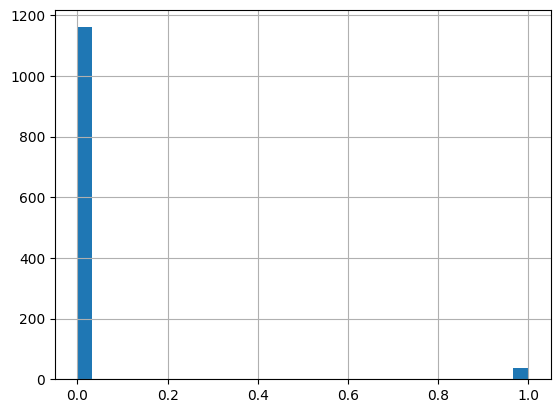

In [108]:
df_encoded["actual_productivity"].hist(bins=30)

In [109]:
model_data=df_encoded.copy()
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   targeted_productivity     1197 non-null   int64
 1   smv                       1197 non-null   int64
 2   over_time                 1197 non-null   int64
 3   incentive                 1197 non-null   int64
 4   actual_productivity       1197 non-null   int64
 5   dia_del_año               1197 non-null   int64
 6   no_of_workers_redondeado  1197 non-null   int64
 7   department_sweing         1197 non-null   int64
 8   day_Saturday              1197 non-null   int64
 9   day_Sunday                1197 non-null   int64
 10  day_Thursday              1197 non-null   int64
 11  day_Tuesday               1197 non-null   int64
 12  day_Wednesday             1197 non-null   int64
 13  team_2                    1197 non-null   int64
 14  team_3                    1197 non-null 

#
Aqui se elige separar el dataset en 80-20 entre los datos de entrenamiento y prueba.

In [110]:
def save_optimal_model_with_data(model_data, n_epochs):
    
    X = model_data.drop('actual_productivity', axis=1)
    y = model_data['actual_productivity']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model1 = Sequential([
        Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(1, activation='linear')
    ])
    model1.compile(optimizer='adam', loss='mean_squared_error')
    model1.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=32)
    y_pred1 = model1.predict(X_test_scaled)
    r2_1 = r2_score(y_test, y_pred1)
    gist_1 = "1 Layer: 32 Neurons (ReLU)"

    model2 = Sequential([
        Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])
    model2.compile(optimizer='adam', loss='mean_squared_error')
    model2.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=32)
    y_pred2 = model2.predict(X_test_scaled)
    r2_2 = r2_score(y_test, y_pred2)
    gist_2 = "2 Layers: 32 Neurons each (ReLU)"

    evaluations = pd.DataFrame({
        'Model': ['Model 1', 'Model 2'], 
        'Out-of-Sample R²': [r2_1, r2_2],
        'Model Gist': [gist_1, gist_2]
    })

    best_model = model1 if r2_1 > r2_2 else model2
    with open('best_model.pkl', 'wb') as file:
        pickle.dump(best_model, file)
    with open('scaler.pkl', 'wb') as file:
        pickle.dump(scaler, file)
    with open('X_data.pkl', 'wb') as file:
        pickle.dump(X, file)

    return evaluations, best_model, scaler, X

evaluations, best_model, scaler, X = save_optimal_model_with_data(model_data, 50)

Epoch 1/50
30/30 [==============================] - 2s 3ms/step - loss: 0.3673
Epoch 2/50
30/30 [==============================] - 0s 3ms/step - loss: 0.1081
Epoch 3/50
30/30 [==============================] - 0s 5ms/step - loss: 0.0647
Epoch 4/50
30/30 [==============================] - 0s 4ms/step - loss: 0.0523
Epoch 5/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0469
Epoch 6/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0426
Epoch 7/50
30/30 [==============================] - 0s 3ms/step - loss: 0.0397
Epoch 8/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0371
Epoch 9/50
30/30 [==============================] - 0s 3ms/step - loss: 0.0351
Epoch 10/50
30/30 [==============================] - 0s 3ms/step - loss: 0.0335
Epoch 11/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0321
Epoch 12/50
30/30 [==============================] - 0s 5ms/step - loss: 0.0308
Epoch 13/50
30/30 [==============================

In [111]:
def summarize_data_for_group(index, standardize=False):
    
    with open('X_data.pkl', 'rb') as file:
        X = pickle.load(file)

    with open('scaler.pkl', 'rb') as file:
        scaler = pickle.load(file)
    
    team_col = f'team_{index}'
    if team_col not in X.columns:
        print(f"Column '{team_col}' not found in the data.")
        return None

    filtered_data = X[X[team_col] == 1]

    summary = filtered_data.mean() 

    if standardize:
        summary = pd.DataFrame([summary])
        summary_scaled = scaler.transform(summary)
        return pd.DataFrame(summary_scaled, columns=summary.columns)

    return pd.DataFrame([summary])

summarize_data_for_group(8)

,targeted_productivity,smv,over_time,incentive,dia_del_año,no_of_workers_redondeado,department_sweing,day_Saturday,day_Sunday,day_Thursday,...,team_3,team_4,team_5,team_6,team_7,team_8,team_9,team_10,team_11,team_12
0,0.0,15.229358,4312.293578,24.880734,34.761468,33.412844,0.513761,0.146789,0.174312,0.155963,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [112]:
summarize_data_for_group(8,standardize=True)

,targeted_productivity,smv,over_time,incentive,dia_del_año,no_of_workers_redondeado,department_sweing,day_Saturday,day_Sunday,day_Thursday,...,team_3,team_4,team_5,team_6,team_7,team_8,team_9,team_10,team_11,team_12
0,0.0,0.084562,-0.05089,-0.085343,-0.04786,-0.018135,-0.106122,-0.01605,0.027699,-0.04355,...,-0.304082,-0.316228,-0.283082,-0.291606,-0.302027,3.182437,-0.304082,-0.278752,-0.276569,-0.310193


In [113]:
def compute_predicted_productivity(index):
    
    with open('best_model.pkl', 'rb') as file:
        model = pickle.load(file)

    summarized_data = summarize_data_for_group(index, standardize=True)
    
    if summarized_data is None or summarized_data.empty:
        print(f"No data available for team {index}.")
        return None

    predicted_productivity = model.predict(summarized_data)

    return predicted_productivity[0] 

compute_predicted_productivity(8)[0]

1/1 [==============================] - 0s 125ms/step


0.165317